# Implémentations de méthodes de création d'images HDR

### Chargement des images utilisées

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

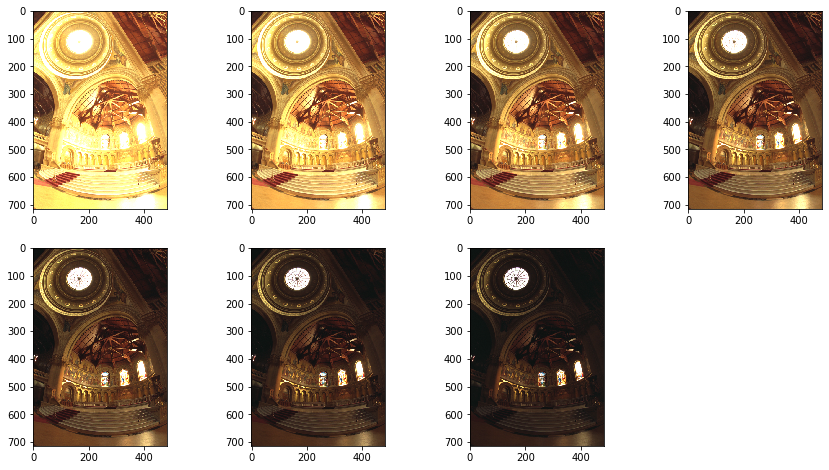

In [2]:
fig=plt.figure(figsize=(15, 8))

imagesMem = []
for i in range(0,7):
    img = cv2.imread('./memorial/memorial0'+str(i)+'.png')
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagesMem.append(img)
    fig.add_subplot(2, 4, i+1)
    plt.imshow(img)
    
plt.show()

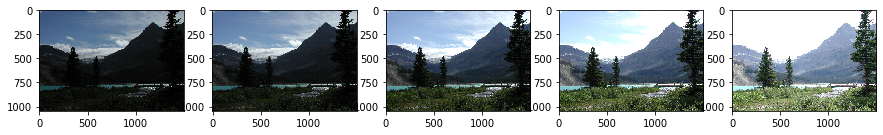

In [3]:
fig=plt.figure(figsize=(15, 15))

imagesA = []
for i in range(0,5):
    img = cv2.imread('./aligned/aligned_'+str(i)+'.bmp')
    imagesA.append(img)
    fig.add_subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
plt.show()

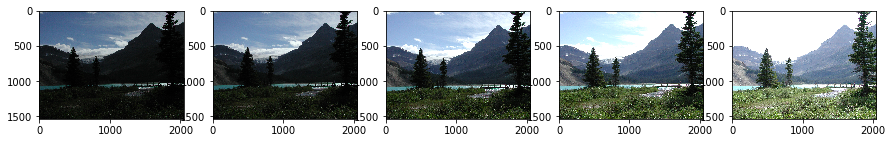

In [4]:
fig=plt.figure(figsize=(15, 15))

imagesNA = []
for i in range(0,5):
    img = cv2.imread('./NonAligned/'+str(i)+'.bmp')
    imagesNA.append(img)
    fig.add_subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
plt.show()

## Rappel de la méthode de Debevec et al. 1997

### Résultats obtenus avec mon implémentation

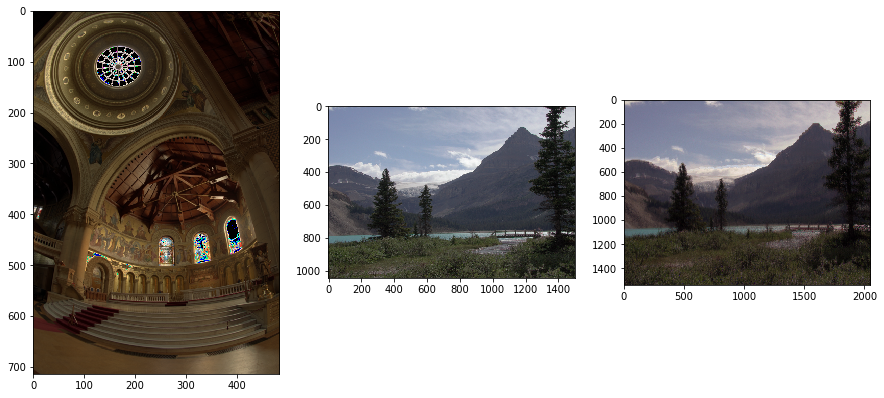

In [5]:
fig=plt.figure(figsize=(15, 15))

img = cv2.imread('./memorial/resultats/Debevec_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 1)
plt.imshow(img)

img2 = cv2.imread('./aligned/resultats/Debevec_res.bmp')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 2)
plt.imshow(img2)

img3 = cv2.imread('./NonAligned/resultats/Debevec_res.bmp')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 3)
plt.imshow(img3)

plt.show()

### Résultats obetenus avec l'implémentation d'OpenCV

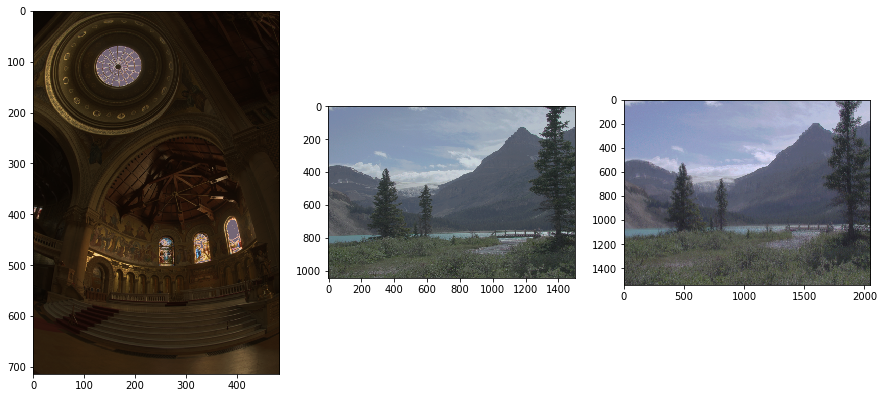

In [6]:
fig=plt.figure(figsize=(15, 15))

img = cv2.imread('./memorial/resultats/OpenCV_ldr.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 1)
plt.imshow(img)

img2 = cv2.imread('./aligned/resultats/OpenCV_ldr.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 2)
plt.imshow(img2)

img3 = cv2.imread('./NonAligned/resultats/OpenCV_ldr.png')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 3)
plt.imshow(img3)

plt.show()

## Implémentation de la méthode de Mertens et al.

### Mon implémentation

Explication cv2.Laplacian = https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html#one-important-matter

In [7]:
def compute_weights(images):

    weights = []
    weights_sum = np.zeros(images[0].shape[:2], dtype=np.float32)
    i = 0
    for image_uint in images:
        image = np.float32(image_uint)/255
        W = np.ones(image.shape[:2], dtype=np.float32)

        # contrast, récupère les éléments importants comme les contours et les textures
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)#image en niveau de gris
        
        #filtre Laplacian sur chaque image
        #cv2.CV_32F = profondeur désirée pour l'image créée, l'image de base est en cv2.CV_8U ou np.uint8
        #cela permet de garder tous les contours (voir lien Explication cv2.Laplacian)
        laplacian = cv2.Laplacian(image_gray, cv2.CV_32F)
        
        #valeur absolue
        W_contrast = np.absolute(laplacian)
        #ajout à l'image de résultat
        W = W_contrast

        
        # saturation
        #calcul de l'écart type sur RGB (axis=2)
        W_saturation = image.std(axis=2, dtype=np.float32)
        #ajout à l'image de résultat
        W = np.multiply(W, W_saturation)

        
        # well-exposedness, pour garder tout ce qui n'est pas sous-exposé ou sur-exposé
        #sigma carré avec un sigma de 0.2
        sigma2 = 0.4 
        #formule donnée dans l'article
        gaussCurve = np.exp(-((image - 0.5)**2)/(2*sigma2)) 
        
        #multiplication du résultat
        W_exposedness = np.prod(gaussCurve, axis=2, dtype=np.float32) 
        #ajout à l'image de résultat
        W = np.multiply(W, W_exposedness)

        
        weights.append(W)
        #utilisé pour la normalisation
        weights_sum += W

    #normalisation
    nonzero = weights_sum > 0 #permet de garder toutes les valeurs qui sont > 0 
    for i in range(len(weights)):
        weights[i][nonzero] /= weights_sum[nonzero]
        weights[i] = np.uint8(weights[i]*255)

    return weights

Explication des deux pyramides : https://theailearner.com/tag/cv2-pyrdown/

In [8]:
def gaussianPyramid(weight, depth, path):
    lower = weight.copy()
    gaussian_pyr = [lower]
    
    for i in range(depth):
        #réduit l'image de moitié
        lower = cv2.pyrDown(lower)
        
        gaussian_pyr.append(lower)
        cv2.imwrite('./'+path+'/resultats/Mertens_resG'+str(i)+'.png',gaussian_pyr[i])

    return gaussian_pyr

In [9]:
def laplacianPyramid(img, depth, path):
    gaussian_pyr=gaussianPyramid(img, depth+1,path)
    laplacian_top = [gaussian_pyr[-1]]
    
    # Create a Laplacian Pyramid
    k = 0
    for i in range(depth+1,0,-1):
        size = (gaussian_pyr[i-1].shape[1], gaussian_pyr[i-1].shape[0])
        
        #agrandit l'image selon la taille calculée size
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        
        laplacian = cv2.subtract(gaussian_pyr[i-1], gaussian_expanded)
        #cv2.imwrite('./'+path+'/resultats/Mertens_resL'+str(k)+'.png',laplacian)
        k=k+1
        
        laplacian_top = [laplacian] + laplacian_top

    return laplacian_top

In [10]:
def pyramid_collapse(pyramid):
    ls_ = pyramid[0]
    for i in range(len(pyramid), 1):
        #l'image est augmentée du double de sa taille
        ls_ = cv2.pyrUp(ls_)
        #elle est ensuite ajoutée à l'image de la pyramide qui a la même taille
        ls_ = cv2.add(ls_, pyramid[i])
        
    return ls_

Fonction principale

In [11]:
def exposure_fusion(images, depth, path):
    
    weights = compute_weights(images)

    # création des pyramides (Gauss, Laplacian)
    laplacian_pyr = []
    gaussian_pyr = []
    k=0 #pour le parcours de weights
    
    for img in images:
        gauss = gaussianPyramid(weights[k], depth, path)
        lapl = laplacianPyramid(img, depth, path)
        laplacian_pyr.append(lapl)
        gaussian_pyr.append(gauss)
        k=k+1

    #calculs avec les images des pyramides
    LS = []
    for l in range(depth+1):
        ls = np.zeros(laplacian_pyr[0][l].shape, dtype=np.uint8)
        for k in range(len(images)):
            lp=laplacian_pyr[k][l]
            
            #les deux images doivent avoir le même type et la même taille (sinon gp fait le double de lp)
            gps_float = np.float32(gaussian_pyr[k][l])/255
            gp = np.dstack((gps_float, gps_float, gps_float))
            
            lp_gp = cv2.multiply(gp, lp, dtype=cv2.CV_8UC3)
            ls = cv2.add(ls, lp_gp)
            
        LS.append(ls)
#         plt.imshow(ls)
#         plt.show()

    #reconstruction d'une image à partir des pyramides
    fusion = pyramid_collapse(LS)
    return fusion

#### Premier test
Images fournises avec le code pour utiliser la méthode de Debvec : https://github.com/opencv/opencv_extra/tree/3.4/testdata/cv/hdr/exposures

In [12]:
fusion = exposure_fusion(imagesMem, 3, 'memorial')
cv2.imwrite('./memorial/resultats/Mertens_res.png', fusion)

True

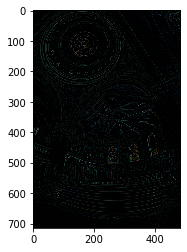

In [13]:
img = cv2.imread('./memorial/resultats/Mertens_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#### Deuxième test
Images alignées

In [14]:
fusion = exposure_fusion(imagesA, 3, 'aligned')
cv2.imwrite('./aligned/resultats/Mertens_res.png', fusion)

True

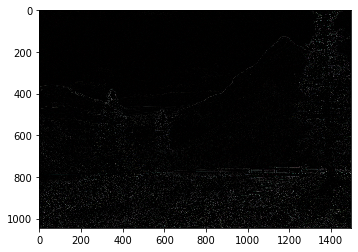

In [15]:
img = cv2.imread('aligned/resultats/Mertens_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#### Troisième test
Images non-alignées

In [16]:
fusion = exposure_fusion(imagesNA, 3, 'NonAligned')
cv2.imwrite('./NonAligned/resultats/Mertens_res.png', fusion)

True

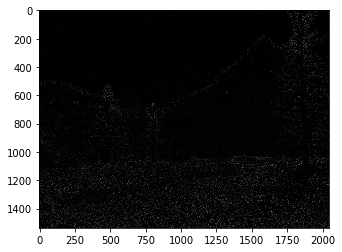

In [17]:
img = cv2.imread('NonAligned/resultats/Mertens_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#### Comparaison avec mon implémentation de la méthode de Debevec
Méthode de Mertens à gauche et celle de Debevec à droite

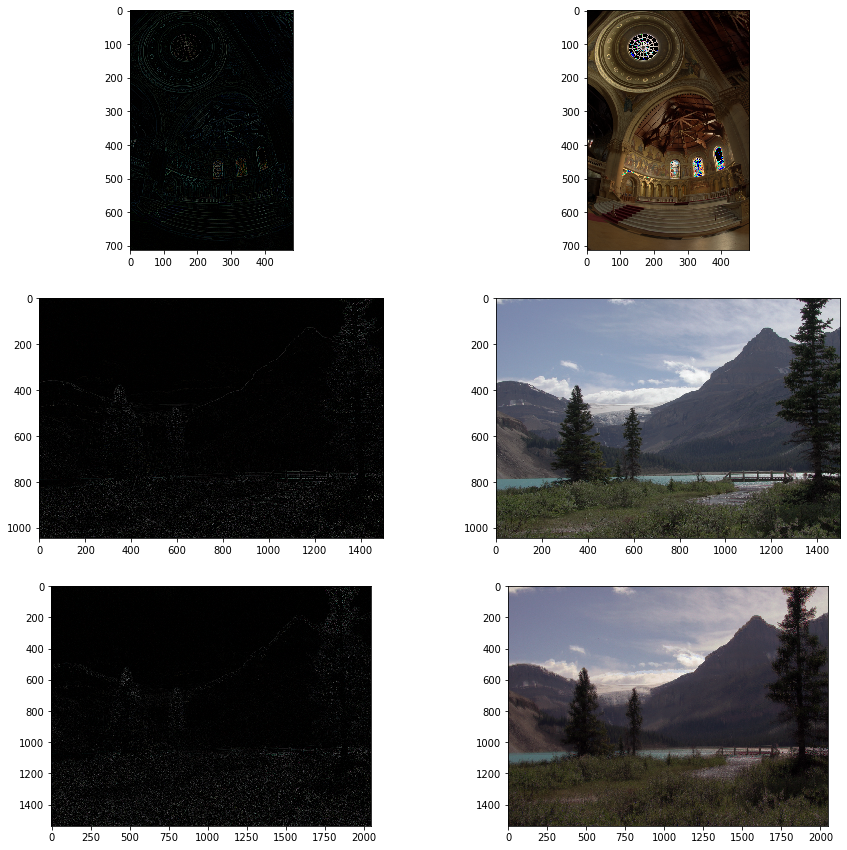

In [18]:
fig=plt.figure(figsize=(15, 15))

#==================memorial==================
img = cv2.imread('memorial/resultats/Mertens_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 1)
plt.imshow(img)

img2 = cv2.imread('memorial/resultats/Debevec_res.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 2)
plt.imshow(img2)

#==================aligned==================
img = cv2.imread('aligned/resultats/Mertens_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 3)
plt.imshow(img)

img2 = cv2.imread('aligned/resultats/Debevec_res.bmp')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 4)
plt.imshow(img2)

#==================NonAligned==================
img = cv2.imread('NonAligned/resultats/Mertens_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 5)
plt.imshow(img)

img2 = cv2.imread('NonAligned/resultats/Debevec_res.bmp')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 6)
plt.imshow(img2)

plt.show()

### Méthode d'OpenCV
Liens utilisés pour comprendre cette méthode :

https://learnopencv.com/exposure-fusion-using-opencv-cpp-python/

https://docs.opencv.org/3.4/d3/db7/tutorial_hdr_imaging.html

#### Premier test
Images fournises avec le code pour utiliser la méthode de Debvec d'OpenCV : https://github.com/opencv/opencv_extra/tree/3.4/testdata/cv/hdr/exposures

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


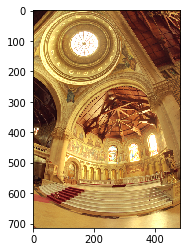

True

In [19]:
mergeMertens = cv2.createMergeMertens()
exposureFusion = mergeMertens.process(imagesMem)

plt.imshow(exposureFusion)
plt.show()
cv2.imwrite('memorial/resultats/OpenCV_Mertens.png', cv2.cvtColor(exposureFusion, cv2.COLOR_BGR2RGB) * 255)

#### Deuxième test
Images alignées

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


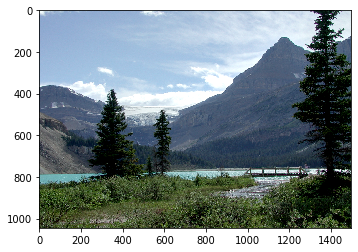

True

In [20]:
mergeMertens = cv2.createMergeMertens()
exposureFusion = mergeMertens.process(imagesA)

plt.imshow(cv2.cvtColor(exposureFusion, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('aligned/resultats/OpenCV_Mertens.png', exposureFusion * 255)

#### Troisième test
Images non-alignées

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


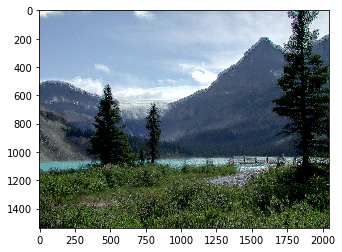

True

In [21]:
mergeMertens = cv2.createMergeMertens()
exposureFusion = mergeMertens.process(imagesNA)

plt.imshow(cv2.cvtColor(exposureFusion, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('NonAligned/resultats/OpenCV_Mertens.png', exposureFusion * 255)

#### Comparaison des méthodes d'OpenCV 
Méthode de Mertens à gauche et celle de Debevec à droite

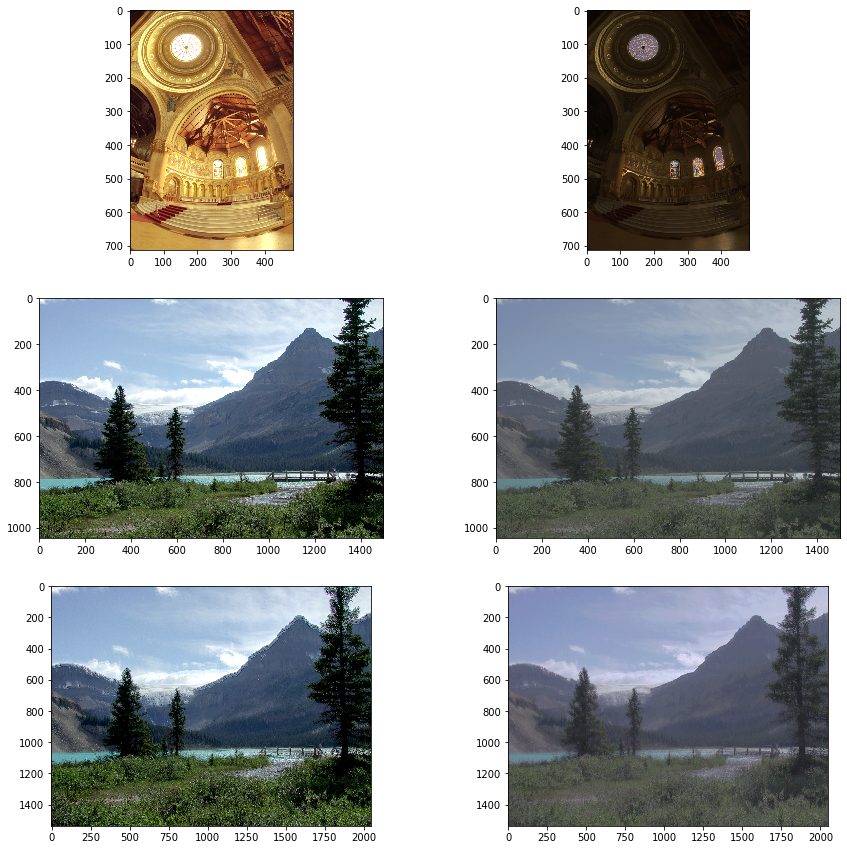

In [22]:
fig=plt.figure(figsize=(15, 15))

#==================memorial==================
img = cv2.imread('memorial/resultats/OpenCV_Mertens.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 1)
plt.imshow(img)

img2 = cv2.imread('./memorial/resultats/OpenCV_ldr.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 2)
plt.imshow(img2)

#==================aligned==================
img = cv2.imread('aligned/resultats/OpenCV_Mertens.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 3)
plt.imshow(img)

img2 = cv2.imread('./aligned/resultats/OpenCV_ldr.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 4)
plt.imshow(img2)

#==================NonAligned==================
img = cv2.imread('NonAligned/resultats/OpenCV_Mertens.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 5)
plt.imshow(img)

img2 = cv2.imread('./NonAligned/resultats/OpenCV_ldr.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 6)
plt.imshow(img2)

plt.show()

## Comparaison des deux résultats
Mon implémentation à gauche et celle d'OpenCV à droite

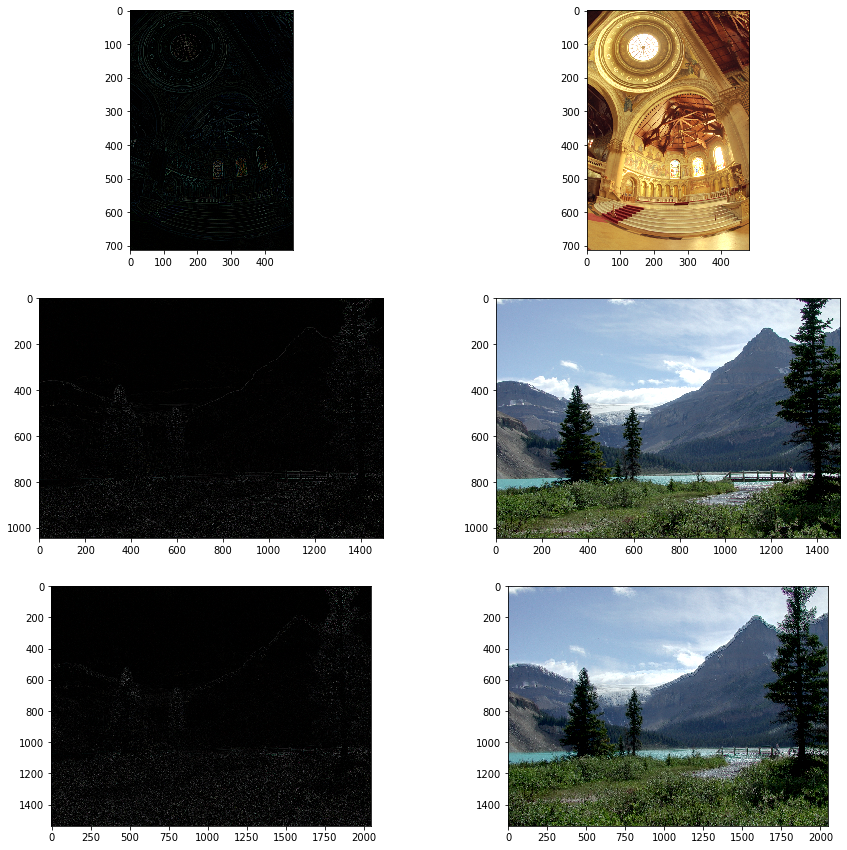

In [23]:
fig=plt.figure(figsize=(15, 15))

#==================memorial==================
img = cv2.imread('memorial/resultats/Mertens_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 1)
plt.imshow(img)

img2 = cv2.imread('memorial/resultats/OpenCV_Mertens.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 2)
plt.imshow(img2)

#==================aligned==================
img = cv2.imread('aligned/resultats/Mertens_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 3)
plt.imshow(img)

img2 = cv2.imread('aligned/resultats/OpenCV_Mertens.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 4)
plt.imshow(img2)

#==================NonAligned==================
img = cv2.imread('NonAligned/resultats/Mertens_res.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 5)
plt.imshow(img)

img2 = cv2.imread('NonAligned/resultats/OpenCV_Mertens.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(3, 2, 6)
plt.imshow(img2)

plt.show()